# Brownian Dynamics Results Analyis
This code was created by Marcus Hock in order to analyze the Brownian Dynamics simulations carried out between myosin and actin. The myosin conformations generated from MSM model construction and analysis, with frames sampled from the different metastable states. 

This analysis is based upon simulations carried out with [Browndye 2.0](https://browndye.ucsd.edu/) using an undefined reaction binding distance, therefore the outputs are frequently considered as binding curves. 

In [1]:
# Import necessary modules 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mdtraj as md
import seaborn as sns
from sklearn.decomposition import PCA
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from tqdm import tqdm 
import pickle 
import os 
import datetime
import pyemma
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


# Make sure the pdfs and SVG's are editable

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# Define two base colors
colors = ['#332288','#44AA99']

# List of HEX colors for ADP 
ADP_colors = ['#8063FF', '#332288', '#281E50']

# List of HEX colors for dADP 
dADP_colors = ['#58E9D3', '#44AA99', '#22564E']

# Full list for the potential different metastable states 
combined_colors= ['#8063FF', '#332288', '#281E50','#58E9D3', '#44AA99', '#22564E']

In [3]:
# Define a class for each iteration of a BD simulation for a metastable state 
# When initialized, when pointing to 

class BD_simulation:
    def __init__(self, simulation_directory, name = ''):
        self.sim_dir = simulation_directory
        self.sim_list = []
        self.pair_list = []
        self.pdb_list = []
        self.complete_pairs = None
        self.sim_name = name
        # Load each simulation
        for i in range(1,15+1):
            #try:
            full_file_path = self.sim_dir + '/cluster_{i}/output_rates.txt'.format(i=i)
            self.sim_list.append(pd.read_csv(full_file_path,delimiter = ' ', names = ['distance','low','average','high']))

            pair_file_path = self.sim_dir + '/cluster_{i}/reaction_pairs.xml'.format(i=i)

            # Load in originally constructed reaction pairs
            temp = pd.read_csv(pair_file_path,
                names = ['pair','myosin','actin','fake_pair'],
                skiprows=1, 
                skipfooter = 1,
                delim_whitespace = True,
                engine = 'python',
                index_col = False,
                )
            temp['combined'] = ''
            for x in temp.index:
                temp.loc[x,'combined'] = (str(temp.myosin[x])+" "+str(temp.actin[x]))
            self.pair_list.append(temp)

            # Load in pdb files for myosin
            pdb_dir = self.sim_dir + '/aligned_structures/myosin_{i}.pqr'.format(i=i)
            self.pdb_list.append(md.load_pdb(pdb_dir))
            #except:
            #   self.sim_list.append(self.sim_list[i-1])
            
        # Load in the entire pair reaction criteria
        pair_file_path = self.sim_dir + '/cluster_{i}/new_reaction_pairs.xml'.format(i=i)
        temp = pd.read_csv(pair_file_path,
            names = ['pair','myosin','actin','fake_pair'],
            skiprows=1, 
            skipfooter = 1,
            delim_whitespace = True,
            engine = 'python',
            index_col = False,
            )
        temp['combined'] = ''
        for x in temp.index:
            temp.loc[x,'combined'] = (str(temp.myosin[x])+" "+str(temp.actin[x]))
        self.complete_pairs= temp
        
        
        
        
    def plot_all(self, color = 'C0', ax = None, label = None):
        if ax == None:
            if label == None: 
                for i in range(len(self.sim_list)):
                    plt.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)
            else: 
                i = 0
                plt.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color, label = label)
                for i in range(1,len(self.sim_list)):
                    plt.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)

                    
        else:
            if label == None:
                for i in range(len(self.sim_list)):
                    ax.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)
            else:
                i = 0 
                ax.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color, label = label)
                for i in range(1,len(self.sim_list)):
                    ax.plot(self.sim_list[i].distance, self.sim_list[i].average, color = color)

    
    def calc_average(self, xmin=4, xmax=100):
        av = np.zeros(1000)
        self.distance_range = np.linspace(xmin,xmax,1000)
        input_df = self.sim_list
        for i in range(15):
            distance_array = input_df[i].distance
            rates_array = input_df[i].average
            interp = np.interp(self.distance_range, distance_array, rates_array)
            av += 1/15*interp 
        self.average = av



In [4]:
# Load in simulations results for the ADP myosin metastable state simulations 

ADP_0 = BD_simulation('bd_adp/metastable_0/', name = 'ADP_0')
ADP_1 = BD_simulation('bd_adp/metastable_1/', name = 'ADP_1')
ADP_2 = BD_simulation('bd_adp/metastable_2/', name = 'ADP_2')


In [5]:
# Load in simulations results for the ADP myosin metastable state simulations 

dADP_0 = BD_simulation('bd_dadp/metastable_0/', name = 'dADP_0')
dADP_1 = BD_simulation('bd_dadp/metastable_1/', name = 'dADP_1')
dADP_2 = BD_simulation('bd_dadp/metastable_2/', name = 'dADP_2')


In [6]:
# Calcualte the average binding curve for each of the metatsble state based on the sampled frames

# Calcualte ADP averages
ADP_0.calc_average()
ADP_1.calc_average()
ADP_2.calc_average()

# Calcualte dADP averages
dADP_0.calc_average()
dADP_1.calc_average()
dADP_2.calc_average()


In [7]:
# Estimate the overall weighted binding rate based on stationary distribution calculated in the MSM analysis. 

# Define weights from MSM stationary distributions
ADP_stationary_dist = [0.34129691367149756, 0.40686952769607276, 0.25183355863242973]

dADP_stationary_dist = [0.04998596184205902, 0.08170875637656712, 0.8683052817813737]

# Estimate weighted average 
ADP_averaged = ADP_stationary_dist[0] * ADP_0.average + ADP_stationary_dist[1] * ADP_1.average + ADP_stationary_dist[2] * ADP_2.average

dADP_averaged = dADP_stationary_dist[0] * dADP_0.average + dADP_stationary_dist[1] * dADP_1.average + dADP_stationary_dist[2] * dADP_2.average

### Visualization of the metastable states and binding frequencies

Text(0.5, 1.0, 'Comparison of Metastable Average Browndye Binding Curves')

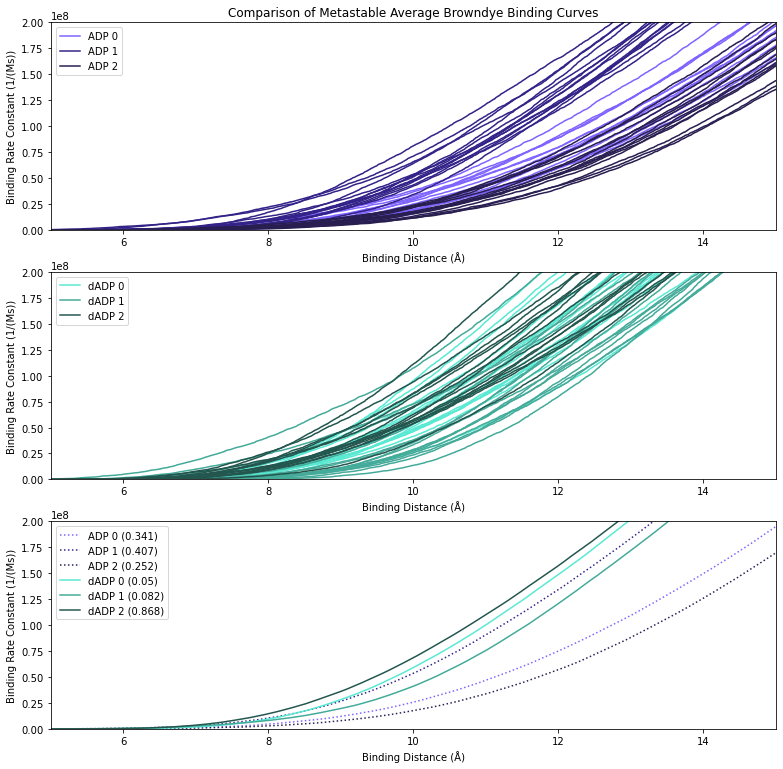

In [8]:
fig, ax = plt.subplots(3,1,figsize = (13, 13))


ADP_0.plot_all(color = ADP_colors[0], label = 'ADP 0', ax = ax[0])
ADP_1.plot_all(color = ADP_colors[1], label = 'ADP 1', ax = ax[0])
ADP_2.plot_all(color = ADP_colors[2], label = 'ADP 2', ax = ax[0])

dADP_0.plot_all(color = dADP_colors[0], label = 'dADP 0', ax = ax[1])
dADP_1.plot_all(color = dADP_colors[1], label = 'dADP 1', ax = ax[1])
dADP_2.plot_all(color = dADP_colors[2], label = 'dADP 2', ax = ax[1])

plt.plot(ADP_0.distance_range, ADP_0.average, ':', label = 'ADP 0 ({})'.format(np.round(ADP_stationary_dist[0],3)), color = ADP_colors[0])
plt.plot(ADP_1.distance_range, ADP_1.average, ':',label = 'ADP 1 ({})'.format(np.round(ADP_stationary_dist[1],3)), color = ADP_colors[1])
plt.plot(ADP_2.distance_range, ADP_2.average, ':',label = 'ADP 2 ({})'.format(np.round(ADP_stationary_dist[2],3)), color = ADP_colors[2])

plt.plot(dADP_0.distance_range, dADP_0.average, label = 'dADP 0 ({})'.format(np.round(dADP_stationary_dist[0],3)), color = dADP_colors[0])
plt.plot(dADP_1.distance_range, dADP_1.average, label = 'dADP 1 ({})'.format(np.round(dADP_stationary_dist[1],3)), color = dADP_colors[1])
plt.plot(dADP_2.distance_range, dADP_2.average, label = 'dADP 2 ({})'.format(np.round(dADP_stationary_dist[2],3)), color = dADP_colors[2])


for i in range(3):
    ax[i].legend(loc = 'upper left')

    ax[i].set_xlim(5,15)
    ax[i].legend()

    ax[i].set_ylim(0,2e8)
    

    ax[i].set_xlabel('Binding Distance (Å)')
    ax[i].set_ylabel('Binding Rate Constant (1/(Ms))')

ax[0].set_title('ADP Browndye Binding Curves')
ax[0].set_title('ADP Browndye Binding Curves')
ax[0].set_title('Comparison of Metastable Average Browndye Binding Curves')




In [9]:
# Estimate the experimental binding rate based on White and Taylor 1976

experimental_binding_rate = 2.5e6 # 1/Ms

exp_distance = np.interp(experimental_binding_rate,ADP_averaged, ADP_0.distance_range )

print("Estimated binding distance: ", exp_distance, "Angstroms")

dADP_rate = np.interp(exp_distance, dADP_0.distance_range, dADP_averaged)
print("Estimated dADP.Pi myosin binding rate:", dADP_rate, "1/Ms")

print("Fold change in binding rate: ",dADP_rate/experimental_binding_rate)


Estimated binding distance:  7.203225892750817 Angstroms
Estimated dADP.Pi myosin binding rate: 4803127.342032957 1/Ms
Fold change in binding rate:  1.9212509368131827


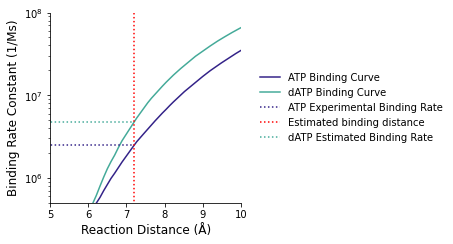

In [10]:
# Create figure for the manuscript to show change in binding rate


fig = plt.figure(figsize = (8.7/2.54,3.5))
plt.plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])

plt.plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
plt.plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
plt.plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

plt.plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')


plt.legend(loc = 'upper left', fontsize = 9)
plt.xlim(5,10)

plt.yscale('log')
plt.ylim(.5e6,1e8)
plt.xlabel('Reaction Distance (Å)', fontsize = 12)
plt.ylabel('Binding Rate Constant (1/Ms)', fontsize = 12)
lgd = plt.legend(loc='center right', 
           bbox_to_anchor=(2.1, .5),

          ncol=1, fancybox=True, shadow=False, 
          frameon = False)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

## Organizing Results for  analysis 
The following functions and cells are generally housekeeping and data movement. Simply used to create a dataframe for the different BD binding curve results, with a specified binding distance. 

In [11]:
# Define a function to take an input BD_simulation instance 
# and given an experimental reaction distance criteria, return 
# the binding rate at that distance in a numpy array 

def get_rates(BD_simulation_group, exp_distance = exp_distance):
    n_sim = len(BD_simulation_group.sim_list)
    results_array = np.zeros(n_sim)
    for i in range(n_sim):
        results_array[i] = np.interp(exp_distance, BD_simulation_group.sim_list[i].distance, 
                                     BD_simulation_group.sim_list[i].average)
    return results_array
        

In [12]:
# The following function builds upon the above and loops thorugh a list of BD instances

def combine_into_super_df(list_of_BD_groups, exp_distance_input = exp_distance):
    results_df = pd.DataFrame(columns = ['sim_name','sample_num','rate'])
        
    for bd_group in list_of_BD_groups:
        new_rate_array = get_rates(bd_group, exp_distance_input)
        n_samples = len(bd_group.sim_list)
        
        input_data = np.column_stack(([bd_group.sim_name]*n_samples, 
                                                 np.arange(1,n_samples+1),
                                                 get_rates(bd_group)))
        
        new_df = pd.DataFrame(data = input_data,
                        columns = ['sim_name','sample_num','rate'])        
        results_df = pd.concat([results_df, new_df])
        
    results_df = results_df.reset_index(drop = True)
    
    results_df['rate'] = results_df['rate'].astype('float64')
    return results_df


In [13]:
# Create a DF with all the estiamted rates from the different BD simulations 

all_rates_df = combine_into_super_df([ADP_0,ADP_1, ADP_2, dADP_0, dADP_1, dADP_2])

all_rates_df

,sim_name,sample_num,rate
0,ADP_0,1,1.935136e+06
1,ADP_0,2,1.991751e+06
2,ADP_0,3,3.883180e+06
3,ADP_0,4,9.463683e+05
4,ADP_0,5,2.394210e+06
...,...,...,...
85,dADP_2,11,5.483106e+06
86,dADP_2,12,4.775002e+06
87,dADP_2,13,9.023730e+06
88,dADP_2,14,4.998381e+06


## Confidence Interval Estimation via bootstrapping
The following cells and section is used to estimate the uncertainty about the binding rates estimated for ATP bound myosin and dATP bound myosin, as it binds to actin. 

In [14]:
# Estimate the proportional contribution of each sampled state from metastable 
# Stationary distribution 

ADP_probabilities = np.concatenate(([ADP_stationary_dist[0]]*15, 
                                   [ADP_stationary_dist[1]]*15, 
                                    [ADP_stationary_dist[2]]*15))/15

ADP_all_rates = np.array(all_rates_df[0:45].rate)

In [15]:
# Estimate the proportional contribution of each sampled state from metastable 
# Stationary distribution 

dADP_probabilities = np.concatenate(([dADP_stationary_dist[0]]*15, 
                                   [dADP_stationary_dist[1]]*15, 
                                    [dADP_stationary_dist[2]]*15))/15

dADP_all_rates = np.array(all_rates_df[45:90].rate)

In [16]:
# Define helper function for estimating the binding rate at a specific binding distance 

def get_bd_rates(bd_sim, distance):
    output_rates = np.zeros(len(bd_sim.sim_list))
    
    i = 0
    for input_df in bd_sim.sim_list:
        output_rates[i] = np.interp(distance, input_df.distance, input_df.average)
        i+=1
    
    return output_rates


In [17]:
# Define another helper function to 

# Inputs should be something like bd_sim_list = [ADP_0,ADP_1,ADP_2], stationary_distribution = ADP_stationary_dist

def bootstrap_CI(bd_sim_list,
                 stationary_dist,
                 lower_bound=0,
                 upper_bound=15,
                 n_points=50,
                 CI = 95,
                 n_bootstraps = 20000):
    # Create array of values to calculate the CI at
    data_range = np.linspace(lower_bound, upper_bound, n_points)
    
    # Create a probabilities array 
    n_metastable_samples = 0
    n_metastable = len(bd_sim_list)
    n_meta_per = len(bd_sim_list[0].sim_list)
    for sim in bd_sim_list:
        n_metastable_samples += len(sim.sim_list)
    
    n_metastable_samples//n_metastable
    all_probabilities = []
    for i in range(n_metastable):
        all_probabilities = np.concatenate((all_probabilities,
            np.full(n_meta_per, stationary_dist[i]/n_meta_per)))
    
    # Test the probailities are correct
    assert np.sum(all_probabilities) <= 1.000001 or np.sum(all_probabilities) >= 0.999999 
    
    lower_array = np.zeros(n_points)
    upper_array = np.zeros(n_points)
    lower_percent = (100-CI)/2
    upper_percent = 100 - (100-CI)/2
    
    print("Lower and upper percentiles of {}% CI: {}, {}".format(CI, lower_percent, upper_percent))
    
    ind = 0 
    for x in tqdm(data_range):
        sim_all_rates = []
        for bd_sim in bd_sim_list:
            
            sim_all_rates = np.concatenate((sim_all_rates,get_bd_rates(bd_sim, x)))
        
        # Defined in the input function 
        # Default is 20,000
        n_samples = n_bootstraps
        rates = np.mean(np.random.choice(sim_all_rates,
                                         p = all_probabilities,
                                         size = (n_metastable_samples,n_samples),
                                         replace = True),
                        axis = 0)
        
        lower_array[ind] = np.percentile(rates, lower_percent)
        upper_array[ind] = np.percentile(rates, upper_percent)
        
        ind += 1 
        

    return data_range, lower_array, upper_array
    


In [18]:
# Estimate the confidence intervals at the specified reaction distance 7.20

distance, lower_bound, upper_bound = bootstrap_CI([ADP_0, ADP_1, ADP_2],
    ADP_stationary_dist,
    exp_distance,exp_distance,1,  95, 500000)

print("Myosin.ATP binding rate: ", 2.5e6)
print("Distance: ",distance[0])
print("Lower:", lower_bound[0])
print("Upper:", upper_bound[0])

Lower and upper percentiles of 95% CI: 2.5, 97.5


100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]

Myosin.ATP binding rate:  2500000.0
Distance:  7.203225892750817
Lower: 1834401.1129993894
Upper: 3294879.3138815784


In [19]:
# Estimate the confidence intervals at the specified reaction distance 7.20

distance, lower_bound, upper_bound = bootstrap_CI([dADP_0, dADP_1, dADP_2],
    dADP_stationary_dist,
    exp_distance,exp_distance,1,  95, 500000)

print("Myosin.dATP binding rate: ", dADP_rate)
print("Distance: ",distance[0])
print("Lower:", lower_bound[0])
print("Upper:", upper_bound[0])

Lower and upper percentiles of 95% CI: 2.5, 97.5


100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

Myosin.dATP binding rate:  4803127.342032957
Distance:  7.203225892750817
Lower: 3983270.6194862155
Upper: 5730029.153159928


In [20]:
# Estiamte the confidence interval over a range of reaction distance criteria 
# from 5 A to 15 A

x_range, lower_ADP, upper_ADP = bootstrap_CI([ADP_0, ADP_1, ADP_2],
                                             ADP_stationary_dist,
                                             5,15,50,  95, 50000)

Lower and upper percentiles of 95% CI: 2.5, 97.5


100%|███████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.54it/s]


In [21]:
# Estiamte the confidence interval over a range of reaction distance criteria 
# from 5 A to 15 A

x_range, lower_dADP, upper_dADP = bootstrap_CI([dADP_0, dADP_1, dADP_2],
                                             dADP_stationary_dist,
                                             5,15,50,  95, 50000)

Lower and upper percentiles of 95% CI: 2.5, 97.5


100%|███████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.65it/s]


Text(0, 0.5, 'Binding Rate (1/Ms)')

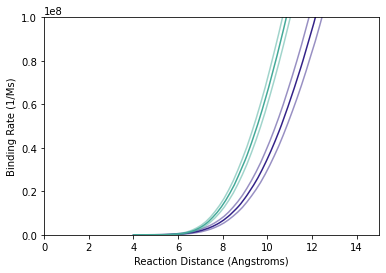

In [22]:
# Plot the confidence invervals vs reaction binding distance 
# for ATP and dATP bound myosin 

plt.plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
plt.plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)
plt.plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
plt.xlim(0,15)
plt.ylim(0,1e8)

plt.plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
plt.plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)
plt.plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
plt.xlim(0,15)
plt.ylim(0,1e8)

plt.xlabel('Reaction Distance (Angstroms)')
plt.ylabel('Binding Rate (1/Ms)')

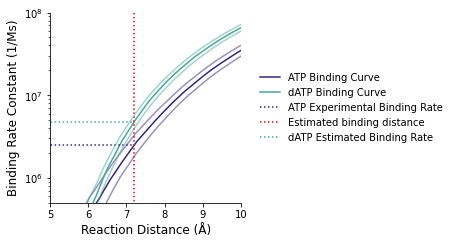

In [23]:
# Adjust above figure to be ylog scale, and publication ready

fig = plt.figure(figsize = (8.7/2.54,3.5))
plt.plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
plt.plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
plt.plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)

plt.plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
plt.plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
plt.plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

plt.plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')
plt.plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
plt.plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)


plt.legend(loc = 'upper left', fontsize = 9)
plt.xlim(5,10)

plt.yscale('log')
plt.ylim(.5e6,1e8)
plt.xlabel('Reaction Distance (Å)', fontsize = 12)
plt.ylabel('Binding Rate Constant (1/Ms)', fontsize = 12)
lgd = plt.legend(loc='center right', 
           bbox_to_anchor=(2.1, .5),

          ncol=1, fancybox=True, shadow=False, 
          frameon = False)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

Lower percentile (2.5%): 1.374017124856051
Upper percentile (97.5%): 2.7549964402811344
P-value:  0.00016


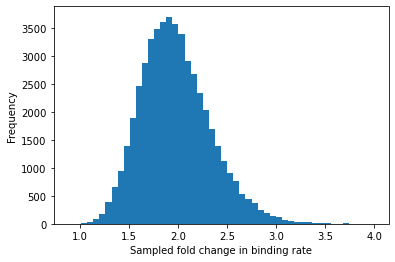

In [24]:
# Bootstrap the ratio of the fold change by geneating
# indpendent estiamtes for ATP bound myosin, and dATP bound myosin 
# then calculating the ratios of each sampled measurement 

# Estimated at the experimental binding distance of 7.20 A

n_samples = 50000

ADP_sampled_rates = np.random.choice(ADP_all_rates,
                 p = ADP_probabilities,
                 size = (45,n_samples),
                 replace = True)


dADP_sampled_rates = np.random.choice(dADP_all_rates,
                 p = dADP_probabilities,
                 size = (45,n_samples),
                 replace = True)



ratios = np.mean(dADP_sampled_rates, axis = 0)/np.mean(ADP_sampled_rates, axis = 0)

# Display distribution:
plt.hist(ratios, bins = 50)
plt.xlabel('Sampled fold change in binding rate')
plt.ylabel('Frequency')

print("Lower percentile (2.5%):", np.percentile(ratios, 2.5))
print("Upper percentile (97.5%):",np.percentile(ratios, 97.5))

print("P-value: ",np.mean(ratios<1))

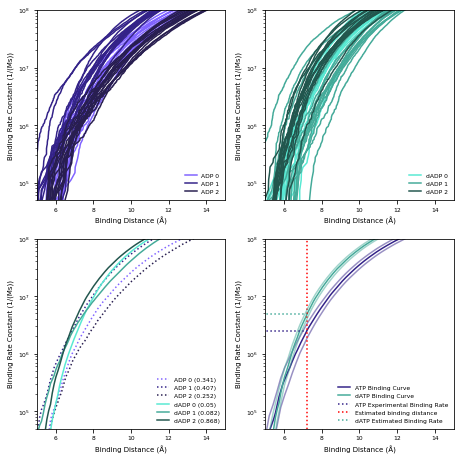

In [25]:
# Create large figure with all sampled states in ylog scale 
# and the confidence intervals plotted in the final pane as well 
# Font size set to small for the publication size 

fig, ax = plt.subplots(2,2,figsize = (6.5, 6.5))


ADP_0.plot_all(color = ADP_colors[0], label = 'ADP 0', ax = ax[0,0])
ADP_1.plot_all(color = ADP_colors[1], label = 'ADP 1', ax = ax[0,0])
ADP_2.plot_all(color = ADP_colors[2], label = 'ADP 2', ax = ax[0,0])

dADP_0.plot_all(color = dADP_colors[0], label = 'dADP 0', ax = ax[0,1])
dADP_1.plot_all(color = dADP_colors[1], label = 'dADP 1', ax = ax[0,1])
dADP_2.plot_all(color = dADP_colors[2], label = 'dADP 2', ax = ax[0,1])

ax[1,0].plot(ADP_0.distance_range, ADP_0.average, ':', label = 'ADP 0 ({})'.format(np.round(ADP_stationary_dist[0],3)), color = ADP_colors[0])
ax[1,0].plot(ADP_1.distance_range, ADP_1.average, ':',label = 'ADP 1 ({})'.format(np.round(ADP_stationary_dist[1],3)), color = ADP_colors[1])
ax[1,0].plot(ADP_2.distance_range, ADP_2.average, ':',label = 'ADP 2 ({})'.format(np.round(ADP_stationary_dist[2],3)), color = ADP_colors[2])

ax[1,0].plot(dADP_0.distance_range, dADP_0.average, label = 'dADP 0 ({})'.format(np.round(dADP_stationary_dist[0],3)), color = dADP_colors[0])
ax[1,0].plot(dADP_1.distance_range, dADP_1.average, label = 'dADP 1 ({})'.format(np.round(dADP_stationary_dist[1],3)), color = dADP_colors[1])
ax[1,0].plot(dADP_2.distance_range, dADP_2.average, label = 'dADP 2 ({})'.format(np.round(dADP_stationary_dist[2],3)), color = dADP_colors[2])




ax[1,1].plot(ADP_0.distance_range, ADP_averaged, label = 'ATP Binding Curve', c= colors[0])
ax[1,1].plot(x_range, lower_ADP, c = colors[0], alpha = 0.5)
ax[1,1].plot(x_range, upper_ADP, c = colors[0], alpha = 0.5)

ax[1,1].plot(dADP_0.distance_range, dADP_averaged, label = 'dATP Binding Curve', c= colors[1])
ax[1,1].plot((0, exp_distance),(2.5e6,2.5e6),':', c = colors[0], label = 'ATP Experimental Binding Rate')
ax[1,1].plot((exp_distance, exp_distance),(0,1e8),':r', label = 'Estimated binding distance ')

ax[1,1].plot((0,exp_distance),(dADP_rate,dADP_rate),':', c=colors[1], label = 'dATP Estimated Binding Rate')
ax[1,1].plot(x_range, lower_dADP, c = colors[1], alpha = 0.5)
ax[1,1].plot(x_range, upper_dADP, c = colors[1], alpha = 0.5)



for i in range(4):
    ax[i//2, i % 2].legend(loc = 'upper left')

    ax[i//2, i % 2].set_xlim(5,15)
    ax[i//2, i % 2].legend(frameon = False, fontsize = 6, loc = 'lower right')

    ax[i//2, i % 2].set_ylim(0,2e8)
    

    ax[i//2, i % 2].set_xlabel('Binding Distance (Å)', fontsize = 7)
    ax[i//2, i % 2].set_ylabel('Binding Rate Constant (1/(Ms))', fontsize = 7)
    ax[i//2, i % 2].set_yscale('log')
    ax[i//2, i % 2].set_ylim(.5e5,1e8)
    ax[i//2, i % 2].tick_params(axis='both', which='major', labelsize=6)
    ax[i//2, i % 2].tick_params(axis='both', which='minor', labelsize=6)
#    ax[i//2, i % 2].


plt.tight_layout()
# fig.savefig('../figures/all_bd_binding_and_weighted_and_CI.svg')

Max fold change:  2.1257532371023298


/tmp/ipykernel_761397/1051763258.py:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(dADP_0.distance_range, dADP_averaged/ADP_averaged, label = 'dADP Binding Curve', c= colors[1])
/tmp/ipykernel_761397/1051763258.py:21: RuntimeWarning: divide by zero encountered in true_divide
  max_fold_change =np.max((dADP_averaged/ADP_averaged)[ADP_0.distance_range>5])


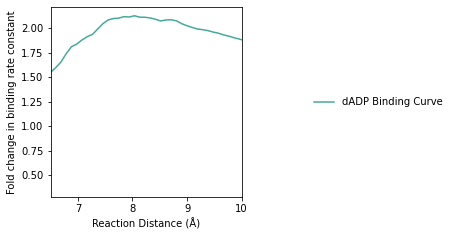

In [26]:
fig = plt.figure(figsize = (8.7/2.54,3.5))


plt.plot(dADP_0.distance_range, dADP_averaged/ADP_averaged, label = 'dADP Binding Curve', c= colors[1])


plt.legend(loc = 'upper left', fontsize = 9)
plt.xlim(6.5,10)

plt.xlabel('Reaction Distance (Å)')
plt.ylabel('Fold change in binding rate constant')
lgd = plt.legend(loc='center right', 
           bbox_to_anchor=(2.1, .5),

          ncol=1, fancybox=True, shadow=False, 
          frameon = False)




max_fold_change =np.max((dADP_averaged/ADP_averaged)[ADP_0.distance_range>5])


print("Max fold change: ", max_fold_change)

## tICA and Binding Rate Correlation Measurement
Load in the information of which frames were sampled from the MSM analysis. These paths may need to be changed if you ran your own analysis. 

In [27]:
# Load pickle data for the sampled frame indices for ADP 

adp_samples_file = "msm_datafiles/adp_sampled_frame_data_bd.pkl"

try:
    f = open(adp_samples_file, 'rb')
    adp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(adp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(adp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print('Could not load file. ')

Loading samples from msm_datafiles/adp_sampled_frame_data_bd.pkl
Modified on:
2024-07-11 10:22:55.392544


In [28]:
# Load pickle data for the sampled frame indices for dADP 

dadp_samples_file = "msm_datafiles/dadp_sampled_frame_data_bd.pkl"

try:
    f = open(dadp_samples_file, 'rb')
    dadp_samples = pickle.load(f)
    f.close()
    print("Loading samples from {}".format(dadp_samples_file))
    print("Modified on:")
    modified = os.path.getctime(dadp_samples_file)
    print(datetime.datetime.fromtimestamp(modified))
except:
    print('Could not load file. ')

Loading samples from msm_datafiles/dadp_sampled_frame_data_bd.pkl
Modified on:
2024-07-11 10:22:59.048624


In [29]:
# Load the loop and COM measurement data for ADP and dADP 

f = open('msm_datafiles/all_loop_COMs_adp.pkl','rb')
ADP_COMS_output = pickle.load(f)
f.close()

f = open('msm_datafiles/all_loop_COMs_dadp.pkl','rb')
dADP_COMS_output = pickle.load(f)
f.close()

In [30]:
# Concatenate data lists
ADP_dADP_COMs_output = [ADP_COMS_output[0],
                        ADP_COMS_output[1],
                        ADP_COMS_output[2],
                        dADP_COMS_output[0],
                        dADP_COMS_output[1],
                        dADP_COMS_output[2]]

In [31]:
inter_region_distances = []
for data_chunk in ADP_dADP_COMs_output:
    new_chunk = []
    for i in range(7):
        for j in range(i+1,7):
            # Calculate the distance X between the two different feature center of masses
            x = np.linalg.norm(data_chunk[:,i*3:i*3+3] - data_chunk[:,j*3:j*3+3], axis = 1)
            new_chunk.append(x)
            
    # Append data for cleft measurements
    new_chunk.append(data_chunk[:,21])
    new_chunk.append(data_chunk[:,22])
    # Reshape the data into a useful array size 
    new_chunk = np.array(new_chunk).reshape(-1,200000).T
    # Append to the full list
    inter_region_distances.append(new_chunk)

# Define the naming convention of the different input features
name_list = ['CM_tip', 'CM_base', 'loop_4_tip', 'loop_4_base', 'loop_2_all', 'loop_2_tip', 'strut_COM']
measure_name_list = []
for i in range(7):
    for j in range(i+1,7):
        measure_name_list.append('COM {} - {}'.format(name_list[i],name_list[j]))
        
measure_name_list.append('DIST: GLN370 CA - LYS540 CA')
measure_name_list.append('DIST: GLY405 CA - LYS540 CA')

In [32]:
formatted_list_name = ['Dist: CM loop tip - CM loop base',
 'Dist: CM loop tip - loop 4 tip',
 'Dist: CM loop tip - loop 4 base',
 'Dist: CM loop tip - loop 2 all',
 'Dist: CM loop tip - loop 2 tip',
 'Dist: CM loop tip - strut COM',
 'Dist: CM loop base - loop 4 tip',
 'Dist: CM loop base - loop 4 base',
 'Dist: CM loop base - loop 2 all',
 'Dist: CM loop base - loop 2 tip',
 'Dist: CM loop base - strut COM',
 'Dist: loop 4 tip - loop 4 base',
 'Dist: loop 4 tip - loop 2 all',
 'Dist: loop 4 tip - loop 2 tip',
 'Dist: loop 4 tip - strut COM',
 'Dist: loop 4 base - loop 2 all',
 'Dist: loop 4 base - loop 2 tip',
 'Dist: loop 4 base - strut COM',
 'Dist: loop 2 all - loop 2 tip',
 'Dist: loop 2 all - strut COM',
 'Dist: loop 2 tip - strut COM',
 'Dist: GLN370 CA - LYS540 CA',
 'Dist: GLY405 CA - LYS540 CA']

In [33]:
# Carry out tICA transform matching the approach used in the MSM analysis

n_dim = 2

tica = pyemma.coordinates.tica(inter_region_distances, dim = n_dim, lag = 20)
tica_output = tica.transform(inter_region_distances)



adp_tica_arrays = []
for meta_n in adp_samples:
    for traj_n, frame_n in meta_n:
        adp_tica_arrays.append(tica_output[traj_n][frame_n])

dadp_tica_arrays = []
for meta_n in dadp_samples:
    for traj_n, frame_n in meta_n:
        dadp_tica_arrays.append(tica_output[traj_n+3][frame_n])

        
all_rates_df['tica_0'] = np.concatenate((adp_tica_arrays, dadp_tica_arrays))[:,0]
all_rates_df['tica_1'] = np.concatenate((adp_tica_arrays, dadp_tica_arrays))[:,1]

calculate covariances:   0%|                                              | 0/6 [00:00<?, ?it/s]

Pearson correlation coefficient: -0.42
P-value: 3.834e-05


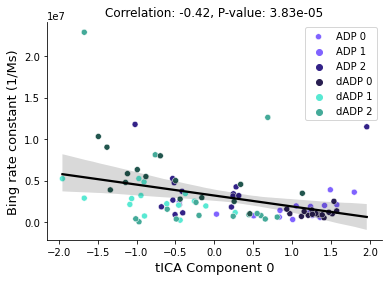

In [34]:
### Investigate relationship beteen the tIC 0 dimmension and the estimated binidng rate 

# Plotting the scatter plot
sns.scatterplot(data=all_rates_df, 
                x='tica_0', 
                y='rate', 
                hue='sim_name', 
                palette=combined_colors)

# Add a regression line using regplot with the same DataFrame and x, y axes
# Set scatter=False to avoid duplicating points
sns.regplot(data=all_rates_df, 
            x='tica_0', 
            y='rate', 
            scatter=False, 
            line_kws={'color': 'black'})  # Customize the color of the line

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = stats.spearmanr(all_rates_df['tica_0'], all_rates_df['rate'])
print("Pearson correlation coefficient: {:.2f}".format(correlation))
print("P-value: {:.3e}".format(p_value))

# Customize the legend for the scatterplot
plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
plt.xlabel('tICA Component 0', fontsize = 13)
# Remove the top right borders 
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

Pearson correlation coefficient: -0.12
P-value: 2.804e-01


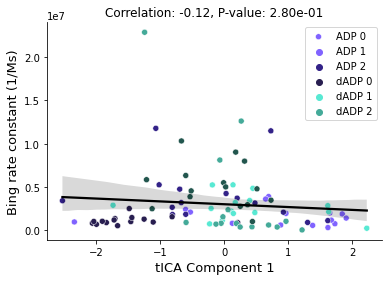

In [35]:
### Investigate relationship beteen the tIC 0 dimmension and the estimated binidng rate 

# Plotting the scatter plot
sns.scatterplot(data=all_rates_df, 
                x='tica_1', 
                y='rate', 
                hue='sim_name', 
                palette=combined_colors)

# Add a regression line using regplot with the same DataFrame and x, y axes
# Set scatter=False to avoid duplicating points
sns.regplot(data=all_rates_df, 
            x='tica_1', 
            y='rate', 
            scatter=False, 
            line_kws={'color': 'black'})  # Customize the color of the line

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = stats.spearmanr(all_rates_df['tica_1'], all_rates_df['rate'])
print("Pearson correlation coefficient: {:.2f}".format(correlation))
print("P-value: {:.3e}".format(p_value))

# Customize the legend for the scatterplot
plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
plt.xlabel('tICA Component 1', fontsize = 13)
# Remove the top right borders 
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
# Show the plot
# plt.savefig('../figures/tica_1_rate_cor.png', dpi = 900)
plt.show()


In [36]:
adp_inter_region_distances = []
for meta_n in adp_samples:
    for traj_n, frame_n in meta_n:
        adp_inter_region_distances.append(inter_region_distances[traj_n][frame_n])
        
dadp_inter_region_distances = []
for meta_n in dadp_samples:
    for traj_n, frame_n in meta_n:
        dadp_inter_region_distances.append(inter_region_distances[traj_n+3][frame_n])

In [37]:
feature_df = pd.DataFrame(np.concatenate((adp_inter_region_distances, dadp_inter_region_distances)), 
            columns = formatted_list_name)

In [38]:
feature_df['rate'] = all_rates_df['rate']
feature_df['sim_name'] = all_rates_df['sim_name']

Pearson correlation coefficient: 0.22
P-value: 3.916e-02


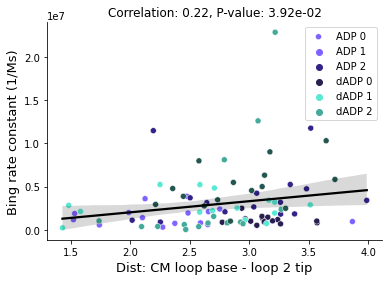

Pearson correlation coefficient: 0.43
P-value: 2.422e-05


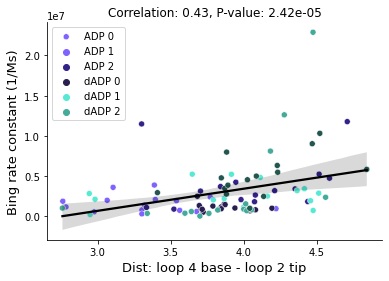

Pearson correlation coefficient: 0.43
P-value: 2.157e-05


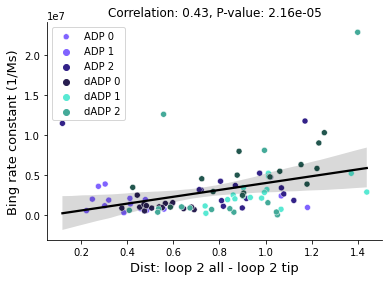

Pearson correlation coefficient: 0.40
P-value: 8.687e-05


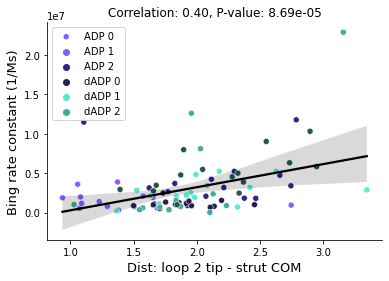

In [39]:
# Investigate relationship between input COM measurement features and the BD binding
# rate for all sampled conformation and plot statistically significant measurements

counter = 0
low_p_list = []
for feature in formatted_list_name:
    corr_r, p_val = stats.spearmanr(feature_df[feature], feature_df.rate)
    if p_val <= 0.05:
        plt.figure()
        sns.scatterplot(data=feature_df, 
                x=feature, 
                y='rate', 
                hue='sim_name', 
                palette=combined_colors)

        # Add a regression line using regplot 
        sns.regplot(data=feature_df, 
                    x=feature, 
                    y='rate', 
                    scatter=False, 
                    line_kws={'color': 'black'})  # Customize the color of the line

        # Calculate the Pearson correlation coefficient and p-value
        correlation, p_value = stats.spearmanr(feature_df[feature], feature_df['rate'])
        print("Pearson correlation coefficient: {:.2f}".format(correlation))
        print("P-value: {:.3e}".format(p_value))

        # Customize the legend for the scatterplot
        plt.legend(['ADP 0','ADP 1','ADP 2','dADP 0','dADP 1','dADP 2'])
        plt.title(f'Correlation: {correlation:.2f}, P-value: {p_value:.2e}')
        plt.ylabel('Bing rate constant (1/Ms)', fontsize = 13)
        plt.xlabel(feature,fontsize = 13)
        # Remove the top right borders 
        ax = plt.gca()
        ax.spines[['right', 'top']].set_visible(False)



    plt.show()
    counter +=1 

In [40]:
# Use the Spearman Correlation for all possible relationships 

corr_list = []

for feature in formatted_list_name:
    
    corr_r, p_val = stats.spearmanr(feature_df[feature], feature_df.rate)
    #corr_r_pears, p_val_pears = stats.spearmanr(feature_df[feature], feature_df.rate)
    corr_list.append((feature,corr_r, p_val,
                      #corr_r_pears, p_val_pears
                     ))
    
corr_df = pd.DataFrame(corr_list, columns = ["Feature","Correlation", "P-value"])

corr_df = corr_df.sort_values(by="P-value").reset_index(drop=True)


In [41]:
# Use Holm-Bonferoni Multiple Comparisons Test to test for significance of relationships

alpha= 0.05
m = len(corr_df)

corr_df["Threshold"] = alpha / (m-corr_df.index.values)

corr_df["Significant"] = corr_df["P-value"] <= corr_df["Threshold"]

corr_df["Threshold"] = alpha / (m-corr_df.index.values)

corr_df



,Feature,Correlation,P-value,Threshold,Significant
0,Dist: loop 2 all - loop 2 tip,0.431666,0.000022,0.002174,True
1,Dist: loop 4 base - loop 2 tip,0.429279,0.000024,0.002273,True
2,Dist: loop 2 tip - strut COM,0.401737,0.000087,0.002381,True
3,Dist: CM loop base - loop 2 tip,0.217829,0.039164,0.002500,False
4,Dist: loop 2 all - strut COM,0.204066,0.053702,0.002632,False
5,Dist: CM loop tip - loop 2 all,-0.167091,0.115467,0.002778,False
6,Dist: loop 4 tip - loop 2 tip,0.153772,0.147886,0.002941,False
7,Dist: CM loop base - loop 4 tip,-0.153607,0.148325,0.003125,False
8,Dist: loop 4 base - loop 2 all,0.146232,0.169041,0.003333,False
9,Dist: CM loop base - loop 4 base,0.127794,0.230008,0.003571,False
